In [1]:
import numpy as np
import bms_env_new
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random


from utils import *


# Import the necessary libraries
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

In [2]:
num_cells = 5
bms = bms_env_new.BMSenv(num_cells= num_cells, k_tanh_params= np.random.uniform(0, 0.2, num_cells), Q_cells =np.random.uniform(2_000, 4_000 ,num_cells))



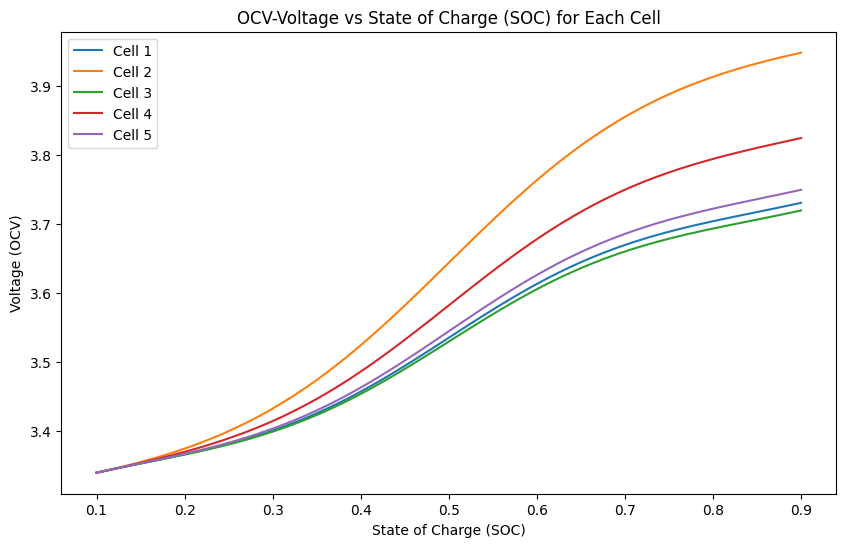

In [3]:
plot_voltage_vs_soc(bms)

In [4]:
T = 20_000

# Always disconected (All the batteries stay still)

In [10]:
bms.reset()
states_1 = [bms.state]
states_voltage_1 = [bms.state_voltage]
actions_1 = []
rewards_1 = []
dones_1 = [False]

while not dones_1[-1] and len(states_1) < T:
    action = [0 for _ in range(num_cells)]
    actions_1.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_1.append(state)
    states_voltage_1.append(bms.state_voltage)
    rewards_1.append(reward)
    dones_1.append(done)

print(f"Sum of rewards: {np.sum(rewards_1)}")

Sum of rewards: -26.644991459265576


In [11]:
len(states_1)

6943

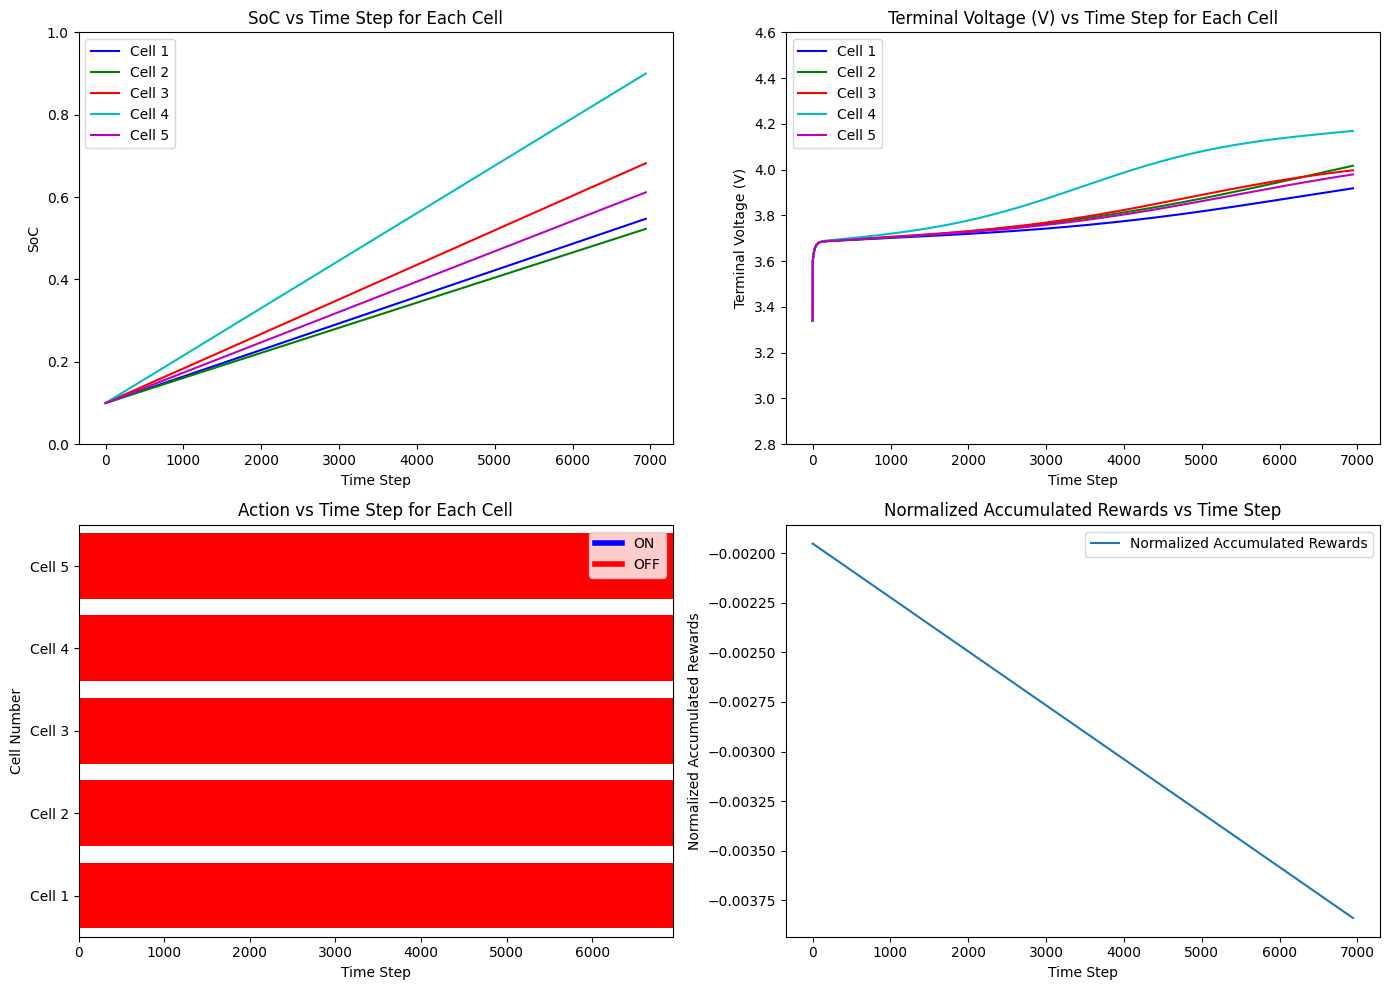

In [7]:
plot_bms_evolution(bms, states_1, states_voltage_1, actions_1, rewards_1, dones_1, include_bad_rewards=True)

# Always connected (All the batteries Discharge)

In [43]:
bms.reset()
states_2 = [bms.state]
states_voltage_2 = [bms.state_voltage]
actions_2 = []
rewards_2 = []
dones_2 = [False]

while not dones_2[-1] and len(states_2) < T:
    action = [1 for _ in range(num_cells)]
    # action = [0, 0, 0, 1, 0]
    actions_2.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_2.append(state)
    states_voltage_2.append(bms.state_voltage)
    rewards_2.append(reward)
    dones_2.append(done)

print(f"Sum of rewards: {np.sum(rewards_2)}")

Sum of rewards: -19.532447831740733


In [44]:
len(states_2)

9539

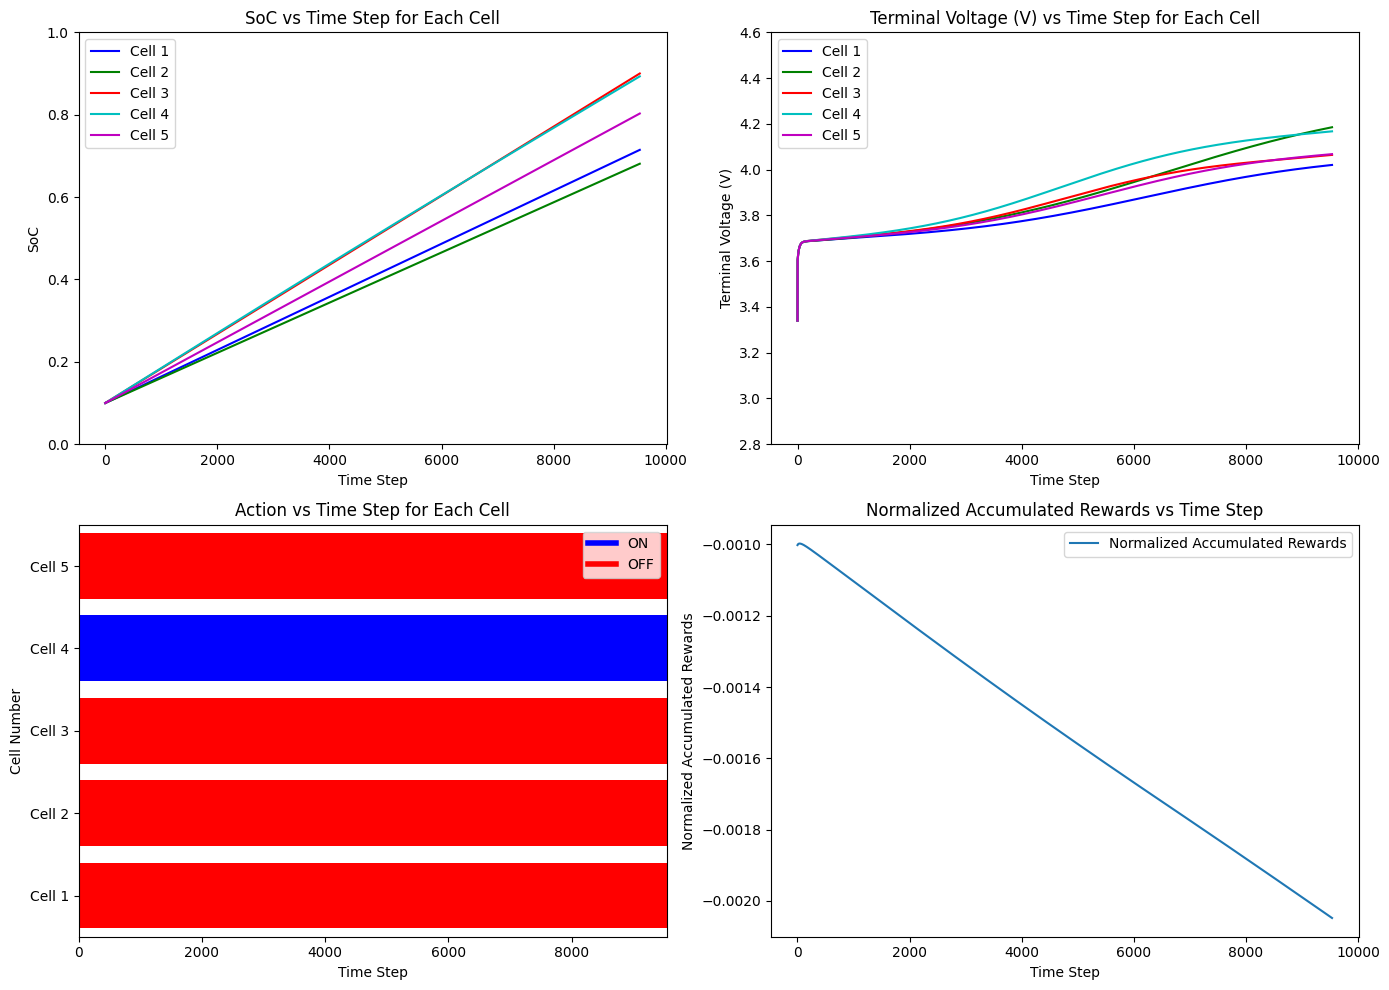

In [45]:
plot_bms_evolution(bms, states_2, states_voltage_2, actions_2, rewards_2, dones_2)

# Random Controller

In [37]:
bms.reset()
states_3 = [bms.state]
states_voltage_3 = [bms.state_voltage]
actions_3 = []
rewards_3 = []
dones_3 = [False]

while not dones_3[-1] and len(states_3) < T:
    action = [np.random.randint(0, 2) for _ in range(num_cells)]
    actions_3.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_3.append(state)
    states_voltage_3.append(bms.state_voltage)
    rewards_3.append(reward)
    dones_3.append(done)

print(f"Sum of rewards: {np.sum(rewards_3)}")

Sum of rewards: -28.733290369636947


In [38]:
len(states_3)

8059

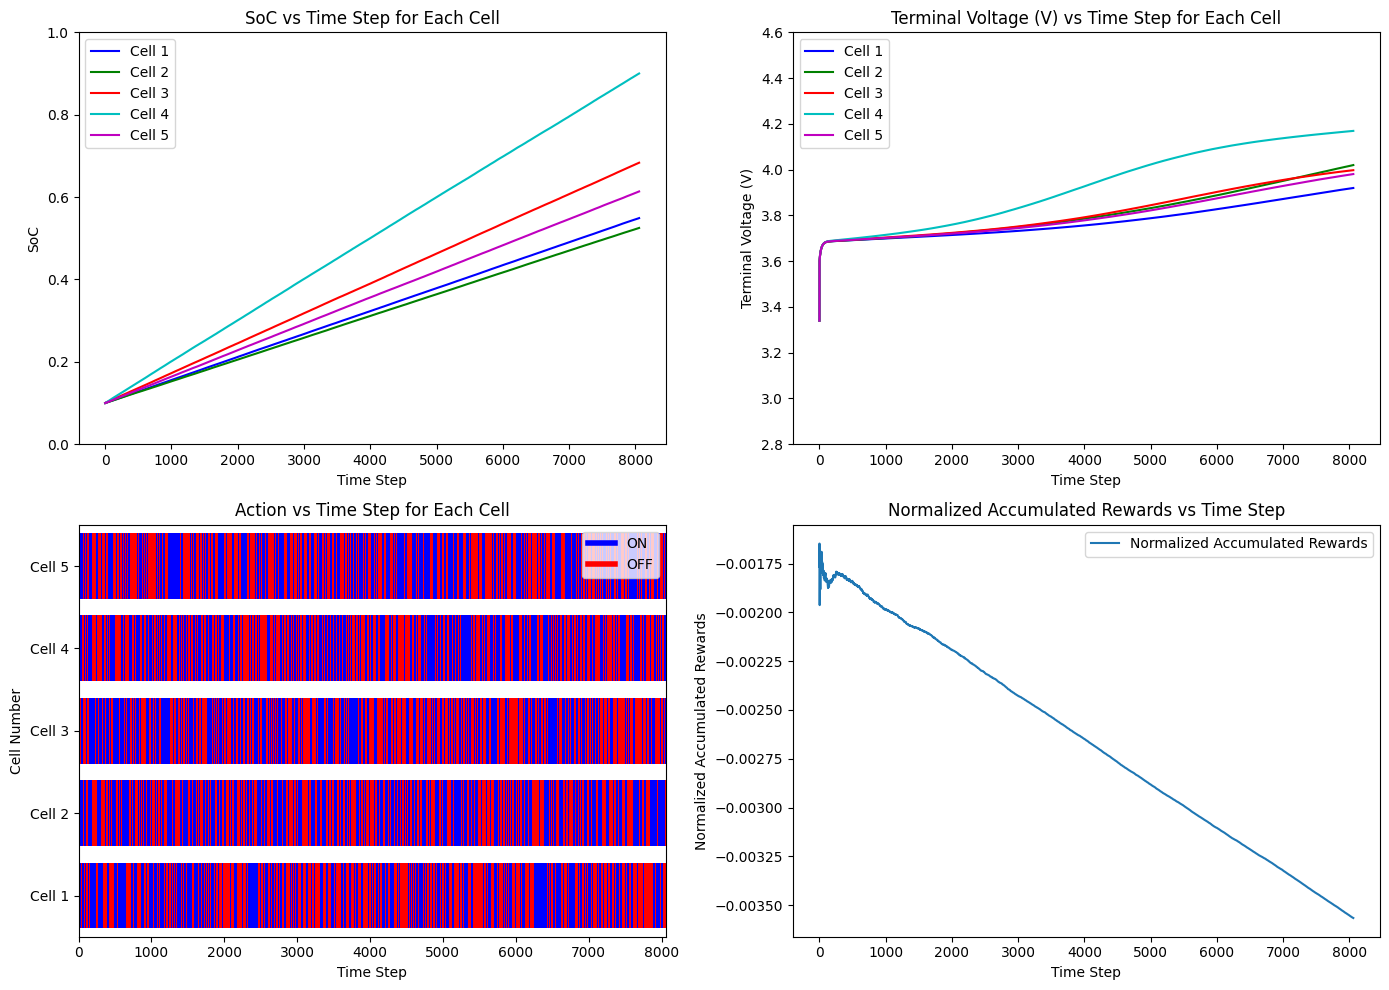

In [39]:
plot_bms_evolution(bms, states_3, states_voltage_3, actions_3, rewards_3, dones_3, include_bad_rewards=True)

# TABULAR Q-Learning

In [9]:
bins = np.array([2.2, 2.5, 2.8, 3, 3.15, 3.30 , 3.40, 3.50 , 3.65, 3.80, 4.0 ,4.2])



In [10]:
bins

array([2.2 , 2.5 , 2.8 , 3.  , 3.15, 3.3 , 3.4 , 3.5 , 3.65, 3.8 , 4.  ,
       4.2 ])

In [11]:
print(bms.int_action_to_switch_action(0))
print(bms.int_action_to_switch_action(1))
print(bms.int_action_to_switch_action(2))
print(bms.int_action_to_switch_action(3))

[0 0 0 0 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 0 1 1]


In [12]:
state_count, action_count = (len(bins) - 1)**bms.num_cells, 2**bms.num_cells
state_count, action_count
Q = np.zeros((state_count, action_count))
Q[:, 0] = -100

bms.reset()
states_6= [bms.state]
states_soc_6 = [bms.state_soc]
actions_6 = []
rewards_6 = []
dones_6 = [False]
random_actions_6 = []
actions_int_6 = []
states_int_6 = [features_to_unique_integer(states_6[-1], bins)]

epsilon = 0.0
stepsize = 0.5
gamma = 0.99

while not dones_6[-1] and len(states_6) < T:

    state_int  = features_to_unique_integer(states_6[-1], bins)

    if np.random.uniform(0, 1) < epsilon:
        random_actions_6.append(True)
        action = bms.action_space.sample()
        # while action == 0:
        #     action = bms.action_space.sample()
    else:
        random_actions_6.append(False)
        # action = np.argmax(Q[state_int, :])
        max_indices = np.flatnonzero(Q[state_int, :] == Q[state_int, :].max())
        action = np.random.choice(max_indices)


    actions_int_6.append(action)

    state, reward, done, _ , _= bms.step(action)
    states_6.append(state)
    states_soc_6.append(bms.state_soc)
    actions_6.append(bms.int_action_to_switch_action(action))
    rewards_6.append(reward)
    dones_6.append(done)


    if not done:
        next_state_int = features_to_unique_integer(state, bins)
        states_int_6.append(next_state_int)
        Q[state_int, action] = Q[state_int, action] + stepsize * (reward + gamma * np.max(Q[next_state_int, :]) - Q[state_int, action])


print(f"Sum of rewards: {np.sum(rewards_6)}")

Sum of rewards: 3.3753805477443226


# Efficient Tabular Q-Learning

In [13]:
state_count, action_count = (len(bins) - 1) ** bms.num_cells, 2 ** bms.num_cells

# Use defaultdict to store Q-values
Q = defaultdict(lambda: [-100] + [0] * (action_count - 1))

bms.reset()
states_6 = [bms.state]
states_soc_6 = [bms.state_soc]
actions_6 = []
rewards_6 = []
dones_6 = [False]
random_actions_6 = []
actions_int_6 = []
states_int_6 = [features_to_unique_integer(states_6[-1], bins)]

epsilon = 0.0
stepsize = 0.5
gamma = 0.99

while not dones_6[-1] and len(states_6) <  T:

    state_int = features_to_unique_integer(states_6[-1], bins)

    if np.random.uniform(0, 1) < epsilon:
        random_actions_6.append(True)
        action = bms.action_space.sample()
    else:
        random_actions_6.append(False)
        # Find the maximum Q-value
        q_values = Q[state_int]
        max_q_value = np.max(q_values)
        # Identify all actions with the maximum Q-value
        max_actions = [a for a, q in enumerate(q_values) if q == max_q_value]
        # Randomly choose one of the actions with the maximum Q-value
        action = random.choice(max_actions)

    actions_int_6.append(action)

    state, reward, done, _, _ = bms.step(action)
    states_6.append(state)
    states_soc_6.append(bms.state_soc)
    actions_6.append(bms.int_action_to_switch_action(action))
    rewards_6.append(reward)
    dones_6.append(done)

    if not done:
        next_state_int = features_to_unique_integer(state, bins)
        states_int_6.append(next_state_int)
        Q[state_int][action] = Q[state_int][action] + stepsize * (
            reward + gamma * max(Q[next_state_int]) - Q[state_int][action]
        )

print(f"Sum of rewards: {np.sum(rewards_6)}")


Sum of rewards: 3.4368680722053155


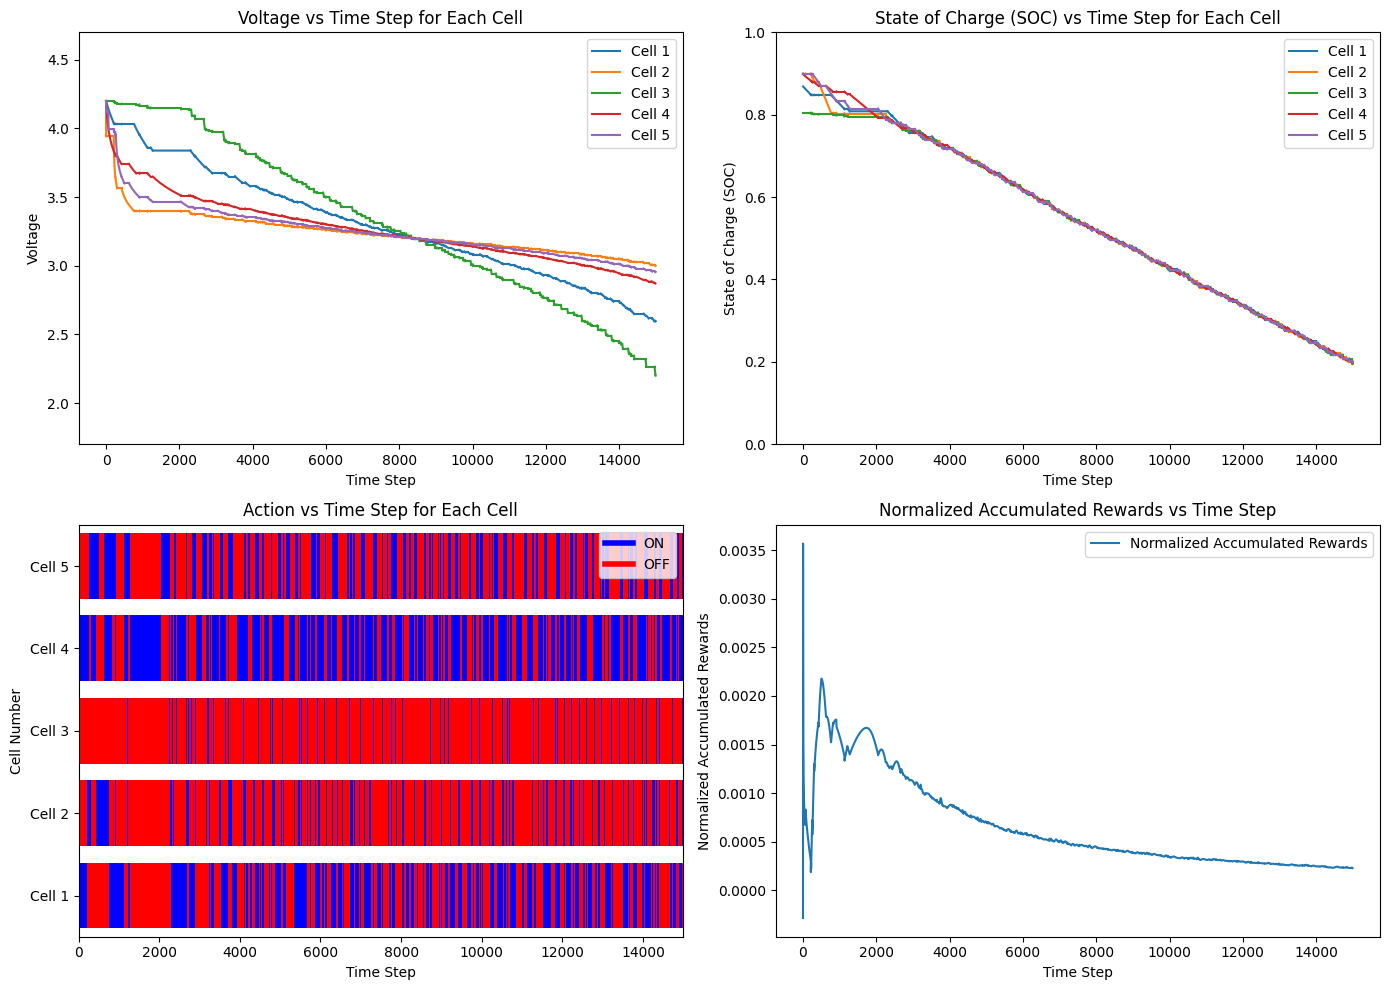

In [14]:
plot_bms_evolution(bms, states_6, states_soc_6, actions_6, rewards_6, dones_6, include_bad_rewards=True)

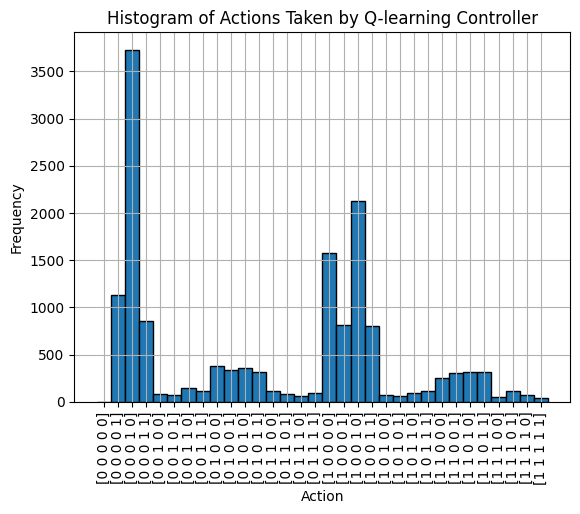

In [15]:
# Generate x-ticks
x_ticks = np.arange(2**bms.num_cells)

# Generate corresponding action arrays
x_tick_labels = [bms.int_action_to_switch_action(action) for action in x_ticks]

# Plot the histogram
plt.hist(actions_int_6, bins=np.arange(2**bms.num_cells + 1) - 0.5, edgecolor='black')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Histogram of Actions Taken by Q-learning Controller')

# Set x-ticks and their labels
plt.xticks(x_ticks, x_tick_labels, rotation=90)  # Rotate labels for better readability

plt.grid(True)
plt.show();

# DQN

In [ ]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [ ]:

# Define the DQN model
# model = DQN('MlpPolicy', bms, verbose=1, exploration_initial_eps = 0.01,
#              exploration_final_eps = 0.01, batch_size= 128, target_update_interval= 5_000)

model = DQN('MlpPolicy', bms, verbose=1, exploration_initial_eps= 0.001,
             exploration_final_eps=0.001, batch_size= 500, target_update_interval= 2_000, learning_rate= 0.0001)

# Train the model
# Note: Start with high epsilon for exploration and gradually reduce it for exploitation.
model.learn(total_timesteps= 250_000)

# Save the model
model.save("dqn_bms")



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.32e+04 |
|    ep_rew_mean      | -120     |
|    exploration_rate | 0.001    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 578      |
|    time_elapsed     | 91       |
|    total_timesteps  | 52798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000222 |
|    n_updates        | 13174    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.24e+04 |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.001    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 586      |
|    time_elapsed     | 169      |
|    total_timesteps  | 99273    |
| train/              |        

In [ ]:
# Load the model
model = DQN.load("dqn_bms")

# Evaluate the model
bms.reset()
states_7 = [bms.state]
states_soc_7 = [bms.state_soc]
actions_7 = []
rewards_7 = []
dones_7 = [False]
actions_int_7 = []

while not dones_7[-1] and len(states_7) <  T:
    action, _ = model.predict(bms.state)
    actions_int_7.append(action)
    state_7, reward_7, done_7, _ , _= bms.step(action)
    states_7.append(state_7)
    states_soc_7.append(bms.state_soc)
    actions_7.append(bms.int_action_to_switch_action(action))
    rewards_7.append(reward_7)
    dones_7.append(done_7)

print(f"Sum of rewards: {np.sum(rewards_7)}")

Sum of rewards: -159.64889290853023


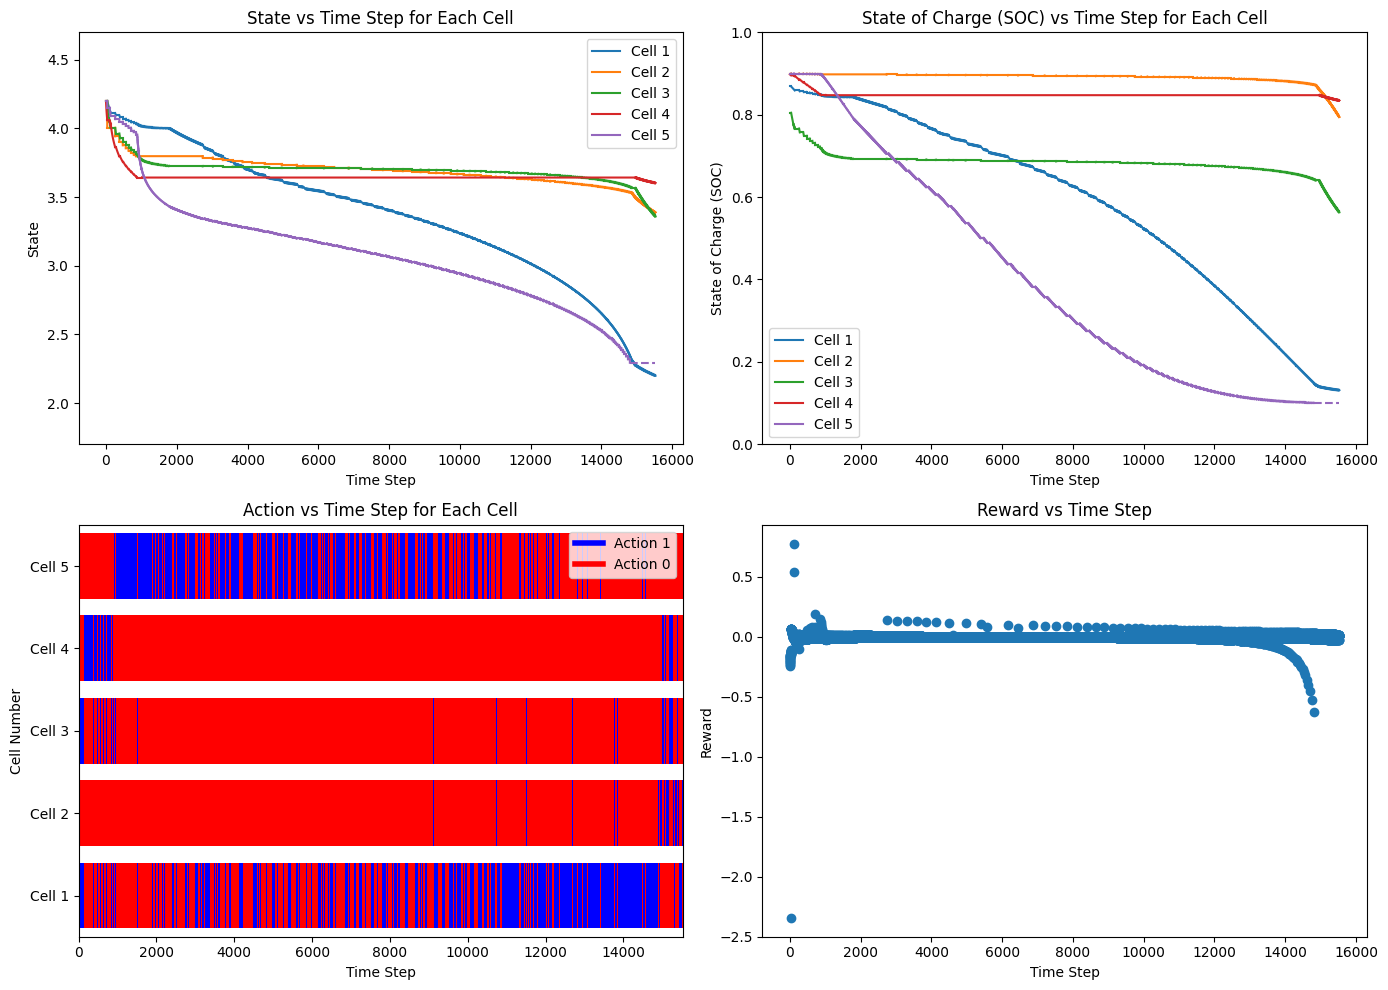

In [ ]:
plot_bms_evolution(bms, states_7, states_soc_7, actions_7, rewards_7, dones_7)